In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [201]:
# Constants
MODEL_NUM = 4
CYCLE_NUM = 4
WINDOW_SIZE = 5

# Velocity data
df_v_label = [
    pd.read_csv('data/model_output/obd/daniel/AtoC/label/AtoC10.csv'),
    pd.read_csv('data/model_output/obd/daniel/CtoD/label/CtoD10.csv'),
    pd.read_csv('data/model_output/obd/daniel/DtoE/label/DtoE10.csv'),
    pd.read_csv('data/model_output/obd/daniel/EtoF/label/EtoF10.csv')
]

df_v_pred = [
    [
        pd.read_csv('data/model_output/obd/daniel/AtoC/prediction/AtoCnaive_avg_train6_test3'),
        pd.read_csv('data/model_output/obd/daniel/AtoC/prediction/AtoC_naive_train6_test3'),
        pd.read_csv('data/model_output/obd/daniel/AtoC/prediction/AtoC_average_test3'),
        pd.read_csv('data/model_output/obd/daniel/AtoC/prediction/AtoC_exp_smoothing3')
    ],
    [
        pd.read_csv('data/model_output/obd/daniel/CtoD/prediction/CtoDnaive_avg_train6_test3'),
        pd.read_csv('data/model_output/obd/daniel/CtoD/prediction/CtoD_naive_train6_test3'),
        pd.read_csv('data/model_output/obd/daniel/CtoD/prediction/CtoD_average_test3'),
        pd.read_csv('data/model_output/obd/daniel/CtoD/prediction/CtoD_exp_smoothing3')
    ],
    [
        pd.read_csv('data/model_output/obd/daniel/DtoE/prediction/DtoE_naive_avg_train6_test3'),
        pd.read_csv('data/model_output/obd/daniel/DtoE/prediction/DtoE_naive_train6_test3'),
        pd.read_csv('data/model_output/obd/daniel/DtoE/prediction/DtoE_average_test3'),
        pd.read_csv('data/model_output/obd/daniel/DtoE/prediction/DtoE_exp_smoothing3')
    ],
    [
        pd.read_csv('data/model_output/obd/daniel/EtoF/prediction/EtoF_naive_avg_train6_test3'),
        pd.read_csv('data/model_output/obd/daniel/EtoF/prediction/EtoF_naive_train6_test3'),
        pd.read_csv('data/model_output/obd/daniel/EtoF/prediction/EtoF_average_test3'),
        pd.read_csv('data/model_output/obd/daniel/EtoF/prediction/EtoF_exp_smoothing3')
    ]
]

# SoC data
df_soc = [
    [
        pd.read_csv('data/soc/obd/daniel/merged/AtoC/AtoC10-NaiveAvg-soc.csv'),
        pd.read_csv('data/soc/obd/daniel/merged/AtoC/AtoC10-Naive-soc.csv'),
        pd.read_csv('data/soc/obd/daniel/merged/AtoC/AtoC10-Average-soc.csv'),
        pd.read_csv('data/soc/obd/daniel/merged/AtoC/AtoC10-ExpSmoothing-soc.csv')
    ],
    [
        pd.read_csv('data/soc/obd/daniel/merged/CtoD/CtoD10-NaiveAvg-soc.csv'),
        pd.read_csv('data/soc/obd/daniel/merged/CtoD/CtoD10-Naive-soc.csv'),
        pd.read_csv('data/soc/obd/daniel/merged/CtoD/CtoD10-Average-soc.csv'),
        pd.read_csv('data/soc/obd/daniel/merged/CtoD/CtoD10-ExpSmoothing-soc.csv')
    ],
    [
        pd.read_csv('data/soc/obd/daniel/merged/DtoE/DtoE10-NaiveAvg-soc.csv'),
        pd.read_csv('data/soc/obd/daniel/merged/DtoE/DtoE10-Naive-soc.csv'),
        pd.read_csv('data/soc/obd/daniel/merged/DtoE/DtoE10-Average-soc.csv'),
        pd.read_csv('data/soc/obd/daniel/merged/DtoE/DtoE10-ExpSmoothing-soc.csv')
    ],
    [
        pd.read_csv('data/soc/obd/daniel/merged/EtoF/EtoF10-NaiveAvg-soc.csv'),
        pd.read_csv('data/soc/obd/daniel/merged/EtoF/EtoF10-Naive-soc.csv'),
        pd.read_csv('data/soc/obd/daniel/merged/EtoF/EtoF10-Average-soc.csv'),
        pd.read_csv('data/soc/obd/daniel/merged/EtoF/EtoF10-ExpSmoothing-soc.csv')
    ]
]

s_v_label = [df_v_label[i].iloc[:, 1] for i in range(CYCLE_NUM)]
s_v_pred = [[df_v_pred[i][j].iloc[:, 1] for j in range(MODEL_NUM)] for i in range(CYCLE_NUM)]

s_soc_label = [df_soc[i][0]['label'] for i in range(CYCLE_NUM)]
s_soc_pred = [[df_soc[i][j]['predict'] for j in range(MODEL_NUM)] for i in range(CYCLE_NUM)]

# Shift 5 steps forward.
def pad_dummy(series, num_rows):
    s = pd.Series([0] * num_rows)
    return s.append(series, ignore_index=True)
    
s_soc_label = [pad_dummy(s_soc_label[i], WINDOW_SIZE)[WINDOW_SIZE:] for i in range(CYCLE_NUM)]
s_soc_pred = [[pad_dummy(s_soc_pred[i][j], WINDOW_SIZE)[WINDOW_SIZE:] for j in range(MODEL_NUM)] for i in range(CYCLE_NUM)]

model_names = [
    'Naive Average',
    'Naive',
    'Average',
    'Exponential Smoothing'
]

In [214]:
def get_xlimit(v_label, unit=10):
    lim = v_label.index[-1]
    if lim % unit == 0:
        lim += unit
    else:
        while lim % unit != 0:
            lim += 1
    return lim

def get_ylimit_v(v_label, v_pred, unit=5):
    lims = []
    lims.append(v_label.max())
    for i in range(MODEL_NUM):
        lims.append(v_pred[i].max())
    lim = max(lims)
    lim = int(lim)
    if lim % unit == 0:
        lim += unit
    else:
        while lim % unit != 0:
            lim += 1
    return lim
    
def get_ylimit_soc(soc_label, soc_pred, unit=0.001):
    lims = []
    lims.append(soc_label.min())
    for i in range(MODEL_NUM):
        lims.append(soc_pred[i].min())
    lim = min(lims)
    lim = round(lim, 3)
    return lim - unit

def get_xtick(v_label, threshold=100):
    if v_label.size > threshold:
        xtick = 20
    else:
        xtick = 10
    return xtick
    
def get_ytick_soc(soc_label, threshold=10):
    min_soc = round(soc_label.min(), 3)
    if (1 - min_soc) * 1000 > threshold:
        ytick = 0.002
    else:
        ytick = 0.001
    return ytick
    
def plot(v_label, v_pred, soc_label, soc_pred):
    row = 2
    col = 4
    
    plt.figure(figsize=(16, 4))
    
    xlimit = get_xlimit(v_label)
    ylimit_v = get_ylimit_v(v_label, v_pred)
    ylimit_soc = get_ylimit_soc(soc_label, soc_pred)
    xtick = get_xtick(v_label)
    ytick_soc = get_ytick_soc(soc_label)

    for i in range(row * col):
        plt.subplot(row, col, i + 1)
        plt.xlim(0, xlimit)
        plt.xticks(np.arange(0, xlimit + 1, xtick))
        plt.grid(True)
        if i < col:
            plt.plot(v_label, label='label')
            plt.plot(v_pred[i], label='prediction')

            plt.title(model_names[i])
            plt.ylim(0, ylimit_v)
            plt.yticks(np.arange(0, ylimit_v + 1, 2))
            if i == 0:
                plt.ylabel('v (m/s)')
                plt.legend()
        else:
            plt.plot(soc_label, label='label')
            plt.plot(soc_pred[i - col], label='prediction')
            
            plt.ylim(ylimit_soc, 1.001)
            plt.yticks(np.arange(ylimit_soc, 1.001, ytick_soc))
            plt.xlabel('t (s)')
            if i == col:
                plt.ylabel('SoC')
                plt.legend()

    plt.show()

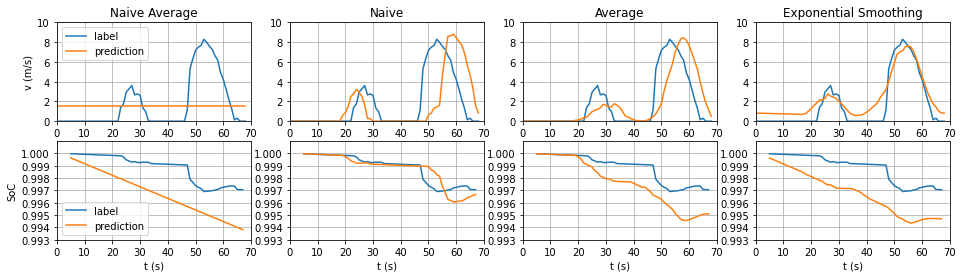

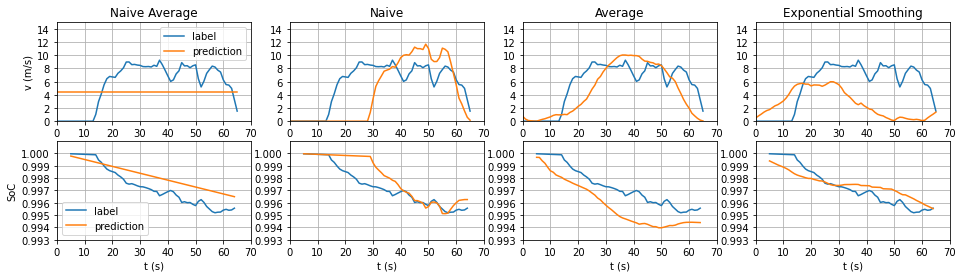

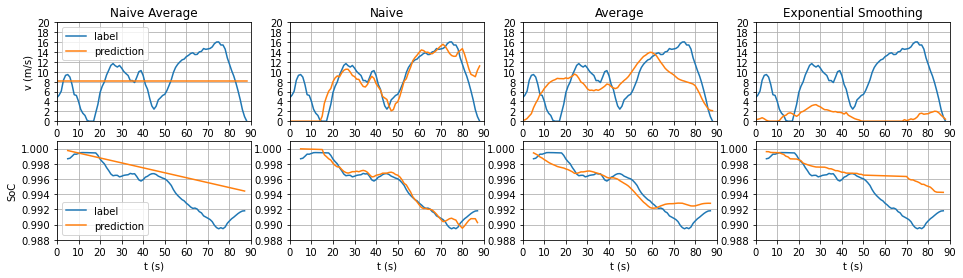

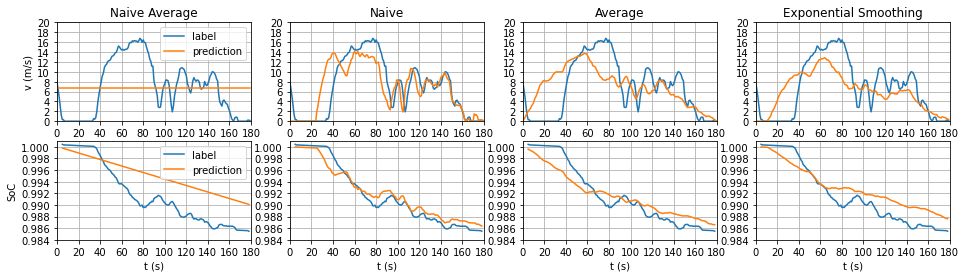

In [217]:
for i in range(CYCLE_NUM):
    plot(s_v_label[i], s_v_pred[i], s_soc_label[i], s_soc_pred[i])